In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import plotly.express as px
import json, csv
from shapely.geometry import Point
from shapely import Polygon

# Predicting Bike-Sharing Demand in Munich

## Data Collection

In [3]:
dfs = []
meta = {'years':[], 'n_columns':[], 'n_rows':[]}
for year in range(2015,2023,1):
    df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
    cols = [col.strip() for col in df.columns]
    df.columns = cols
    dfs.append(df)
    meta['years'].append(year)
    meta['n_columns'].append(df.shape[1])
    meta['n_rows'].append(df.shape[0])
    
meta_df = pd.DataFrame(meta).set_index('years')
meta_df

/tmp/ipykernel_14774/3714795283.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
/tmp/ipykernel_14774/3714795283.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
/tmp/ipykernel_14774/3714795283.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
/tmp/ipykernel_14774/3714795283.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
/tmp/ipykernel_14774/3714795283.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../

,n_columns,n_rows
years,,
2015,11,49812
2016,11,342395
2017,11,418982
2018,11,435868
2019,11,753678
2020,11,721752
2021,11,619573
2022,11,709144


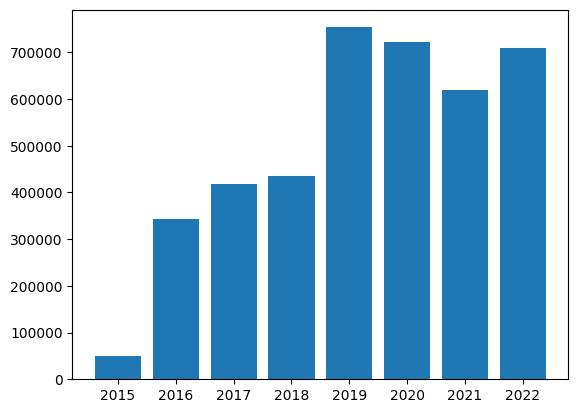

In [4]:
# Data quantity for every year
plt.bar(meta_df.index, meta_df['n_rows']);

In [5]:
# Columns available for every year
meta_df['n_columns'] == 11

years
2015    True
2016    True
2017    True
2018    True
2019    True
2020    True
2021    True
2022    True
Name: n_columns, dtype: bool

In [6]:
def pre_process_df(df):
  #vstrip column names
  cols = [col.strip() for col in df.columns]
  df.columns = cols

  # remove column 'Row'
  if 'Row' in df.columns:
    df.drop(columns='Row', inplace=True)

  # select relevant columns only
  df = df[['STARTTIME', 'STARTLAT', 'STARTLON', 'RENTAL_IS_STATION', 'RENTAL_STATION_NAME']].copy()
  
  # make string replacements values
  df_obj = df.select_dtypes(include='object')
  df[df_obj.columns] = df_obj.applymap(lambda x: x.strip().replace(',', '.') if isinstance(x, str) else x)

  # handle datetime
  df.STARTTIME = pd.to_datetime(df.STARTTIME)

  # handle numeric columns
  df = df.dropna()
  df.drop(df[df['RENTAL_IS_STATION'] == 'NULL'].index, inplace = True)
  df[['STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']] = df[['STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']].astype(np.float32)
  
  return df

In [7]:
dfs_preproc = []
for df in dfs[4:]:
  dfs_preproc.append(pre_process_df(df))

df_all = pd.concat(dfs_preproc, axis=0).reset_index().drop(columns='index')
print(df_all.shape)
df_all.head(2)

(2804130, 5)


,STARTTIME,STARTLAT,STARTLON,RENTAL_IS_STATION,RENTAL_STATION_NAME
0,2019-01-01 00:26:00,48.11845,11.51556,1.0,Westpark
1,2019-01-01 00:32:00,48.13829,11.56943,0.0,


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2804130 entries, 0 to 2804129
Data columns (total 5 columns):
 #   Column               Dtype         
---  ------               -----         
 0   STARTTIME            datetime64[ns]
 1   STARTLAT             float32       
 2   STARTLON             float32       
 3   RENTAL_IS_STATION    float32       
 4   RENTAL_STATION_NAME  object        
dtypes: datetime64[ns](1), float32(3), object(1)
memory usage: 74.9+ MB


In [9]:
df_all.isna().sum()

STARTTIME              0
STARTLAT               0
STARTLON               0
RENTAL_IS_STATION      0
RENTAL_STATION_NAME    0
dtype: int64

In [10]:
# duplicate_count = df_all.duplicated().sum()
# duplicate_count

In [11]:
print(df_all['RENTAL_IS_STATION'].value_counts())

RENTAL_IS_STATION
0.0    1998237
1.0     805893
Name: count, dtype: int64


In [12]:
df_all['year'] = df_all['STARTTIME'].map(lambda x : x.year)
df_all['month'] = df_all['STARTTIME'].map(lambda x : x.month)
df_all['hour'] = df_all['STARTTIME'].map(lambda x : x.hour)
df_all['date_hour'] = df_all['STARTTIME'].dt.floor('H')

In [13]:
print(df_all.shape)
df_all.head(3)

(2804130, 9)


,STARTTIME,STARTLAT,STARTLON,RENTAL_IS_STATION,RENTAL_STATION_NAME,year,month,hour,date_hour
0,2019-01-01 00:26:00,48.118450,11.51556,1.0,Westpark,2019,1,0,2019-01-01
1,2019-01-01 00:32:00,48.138290,11.56943,0.0,,2019,1,0,2019-01-01
2,2019-01-01 00:49:00,48.170971,11.57294,1.0,Scheidplatz,2019,1,0,2019-01-01


## Adding Districts and Grouping by Hour

In [14]:
polygons = {}
# load coordinates for districts from csv and save them in a dict of Polygons
with open('../raw_data/polygons.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        polygons[row['district']] = Polygon(json.loads(row['coordinates']))

In [19]:
polygons

{'Maxvorstadt': <POLYGON ((11.539 48.143, 11.54 48.143, 11.542 48.143, 11.544 48.142, 11.545...>,
 'Schwabing-West': <POLYGON ((11.55 48.161, 11.55 48.161, 11.551 48.16, 11.551 48.16, 11.552 48...>,
 'Au - Haidhausen': <POLYGON ((11.569 48.122, 11.569 48.122, 11.569 48.122, 11.57 48.122, 11.57 ...>,
 'Sendling': <POLYGON ((11.535 48.13, 11.536 48.13, 11.536 48.13, 11.536 48.129, 11.536 4...>,
 'Schwanthalerhöhe': <POLYGON ((11.526 48.137, 11.526 48.137, 11.526 48.136, 11.526 48.136, 11.52...>,
 'Moosach': <POLYGON ((11.466 48.205, 11.466 48.204, 11.467 48.204, 11.468 48.204, 11.46...>,
 'Berg am Laim': <POLYGON ((11.601 48.124, 11.602 48.124, 11.604 48.123, 11.606 48.121, 11.60...>,
 'Trudering': <POLYGON ((11.644 48.115, 11.644 48.115, 11.646 48.114, 11.647 48.113, 11.64...>,
 'Ramersdorf': <POLYGON ((7.14 50.718, 7.143 50.718, 7.145 50.717, 7.147 50.717, 7.147 50.7...>,
 'Obergiesing': <POLYGON ((11.574 48.112, 11.574 48.112, 11.574 48.112, 11.574 48.112, 11.57...>,
 'Untergiesing': 

In [20]:
df_all['geo_points'] = df_all[['STARTLON', 'STARTLAT']].apply(lambda x: Point(x.STARTLON, x.STARTLAT), axis=1)

for district, poly in polygons.items():
    df_all[district] = df_all.apply(lambda x: poly.contains(x.geo_points), axis=1)
    
df_all.head(3)

: 

: 

In [ ]:
df_all[['STARTTIME', 'date_hour']] = df_all[['STARTTIME', 'date_hour']].apply(pd.to_datetime)

relevant_cols = list(set(df_all.columns) - set(['STARTTIME', 'STARTLAT', 'STARTLON', 'geo_points']))
agg_dict = {col: np.mean 
            if col in ['RENTAL_IS_STATION', 'year', 'month', 'hour', 'date_hour'] 
            else np.sum 
            for col in relevant_cols}

df_by_hour = df_all[relevant_cols].groupby('date_hour').agg(agg_dict)
df_by_hour.reset_index(drop=True, inplace=True)
print(df_by_hour.shape)
df_by_hour.head()

## Aggregating with Weather Data

In [ ]:
url = "https://archive-api.open-meteo.com/v1/era5"
params = {
    'latitude': 48.14,
    'longitude': 11.58, 
    'start_date': '2019-01-01',
    'end_date': '2022-12-31',
    'hourly': ['temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'windspeed_10m', 'precipitation']
}

weather_data = requests.get(url, params=params).json()

In [ ]:
weather_data_hourly = weather_data['hourly']
df_weather = pd.DataFrame(weather_data_hourly)
print(df_weather.shape)
df_weather.head()

In [ ]:
df_weather['time'] = pd.to_datetime(df_weather['time'])

data = df_by_hour.merge(df_weather, left_on='date_hour', right_on='time', how='left').drop(columns='time')
print(data.shape)
data.head(2)

In [ ]:
data['date_hour'] = data['date_hour'].apply(pd.to_datetime)
data.head(2)

In [ ]:
data.columns